# **Image Classification Using the EfficientNetV2L Model**

In this notebook, the pre-trained [EfficientNetV2L](https://arxiv.org/abs/2104.00298#) model is used for image classification on the [CIFAR-10](https://www.cs.toronto.edu/%7Ekriz/cifar.html) dataset. This dataset comprises 60,000 RGB images, with 50,000 used for training and 10,000 for testing. EfficientNetV2L is a convolutional neural network pre-trained on the [ImageNet21K](https://github.com/Alibaba-MIIL/ImageNet21K) dataset. Compared to previous versions such as [EfficientNet](https://arxiv.org/abs/1905.11946), EfficientNetV2L provides faster training and requires fewer parameters, while achieving better results.

Initially, transfer learning is applied to adapt the features of the EfficientNetV2L base model to the CIFAR-10 classes. The original classification layers are removed, all base model layers are frozen to prevent them from being trained, and new classification layers specific to CIFAR-10 are added, matching the number of classes in the CIFAR-10 dataset. Subsequently, fine-tuning is performed by unfreezing the top layers of the base model, allowing their weights to be adjusted. This process enables the transformation of generic feature maps into features specific to CIFAR-10, effectively leveraging the general knowledge of the pre-trained model and adapting it to a new classification task with a smaller, more specific dataset.

Better results have been achieved in the notebook [ImageClassification_ViT_CIFAR-10](https://github.com/JersonGB22/ImageClassification-TensorFlow/blob/main/BasicModels/ImageClassification_ViT_CIFAR-10.ipynb), reaching an accuracy of **99.02%** on the test dataset.

## **Imports**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
epochs = 50
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
image_size = (300, 300, 3)

## **Prepare the dataset for training**

### **Load the dataset**

In [ ]:
(train_dataset, test_dataset), info = tfds.load("cifar10", split=["train", "test"], as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learni

In [ ]:
num_classes = info.features["label"].num_classes
class_names = info.features['label'].names

print("Number of classes:", num_classes)
print("Class names:", class_names)

Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### **Preprocessing and data augmentation**

To combat overfitting, it is essential to use data augmentation techniques, especially since the training dataset is relatively small. Data augmentation will help improve the model's generalization ability for image classification. To achieve this, TensorFlow's `RandomFlip`, `RandomTranslation`, `RandomRotation`, and `RandomZoom` layers will be utilized. These layers should only be applied to the training dataset during preprocessing, which is controlled by setting the `training=True` parameter. Additionally, the `Resizing` layer will be employed to scale CIFAR-10 images to a larger size, as larger images generally yield better results (although this requires more training time). This layer operates independently of the `training` parameter.

Finally, it is important to note that while transfer learning and fine-tuning typically require applying specific normalization for the base model, pre-trained EfficientNet and EfficientNetV2 models already include an initial normalization layer in their architecture, so this additional normalization is not necessary.

In [ ]:
def function_data_augmentation(input_shape):
  inputs = tf.keras.Input(shape=input_shape)

  x = tf.keras.layers.Resizing(image_size[0], image_size[1])(inputs)
  x = tf.keras.layers.RandomFlip("horizontal")(x)
  x = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
  x = tf.keras.layers.RandomRotation(0.1)(x)
  x = tf.keras.layers.RandomZoom(0.2)(x)
  #x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

  return tf.keras.Model(inputs=inputs, outputs=x, name="data_augmentation")

In [ ]:
data_augmentation = function_data_augmentation((32, 32, 3))

In [ ]:
def prepare_dataset(dataset, training=True):
  if training:
    dataset = dataset.shuffle(buffer_size, seed=SEED)

  dataset = (
      dataset.
      batch(batch_size).
      map(lambda x, y : (data_augmentation(x, training=training), y), num_parallel_calls=AUTOTUNE).
      prefetch(AUTOTUNE)
  )

  return dataset

In [ ]:
train_dataset = prepare_dataset(train_dataset)
test_dataset = prepare_dataset(test_dataset, training=False)

In [ ]:
# Take a batch from the training dataset
for images, labels in train_dataset.take(1):
  print(images.shape, labels.shape)

images.numpy().min(), images.numpy().max()

(128, 300, 300, 3) (128,)


(0.0, 255.0)

**Function to display and save images**

In [ ]:
def show_images(images, labels, predictions=None, num_examples=36, random=True,
                cmap=None, axis="off", save=False, path=""):

  n = int(np.sqrt(num_examples))
  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, axes = plt.subplots(n, n, figsize=(1.25*n, 1.25*n))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[indices[i]], cmap=cmap)

    if predictions is not None:
      color = "#00008B" if labels[indices[i]] == predictions[indices[i]] else "red"

      ax.text(
          x=0.5, y=1.11, s=f"Label: {class_names[labels[indices[i]]]}", color=color, fontsize=6.75,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )
      ax.text(
          x=0.5, y=1, s=f"Pred: {class_names[predictions[indices[i]]]}", color=color, fontsize=6.75,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    else:
      ax.text(
          x=0.5, y=1, s=f"Label: {class_names[labels[indices[i]]]}", fontsize=7,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    ax.axis(axis)

  # Save images
  if save:
    plt.savefig(path)

  plt.tight_layout()
  plt.show()

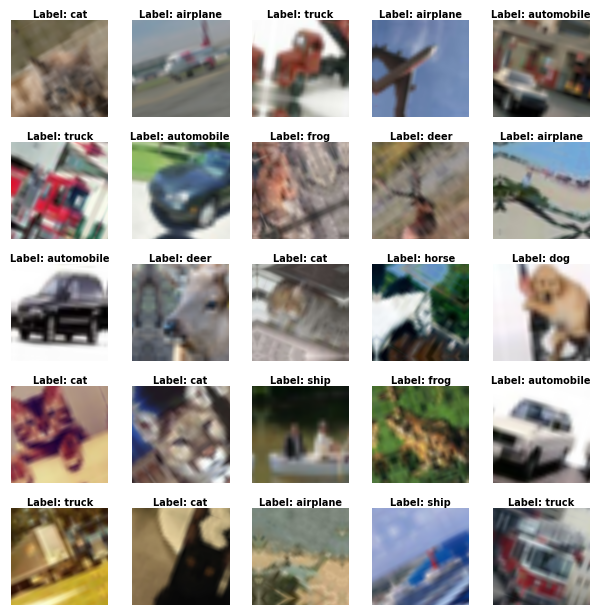

In [ ]:
# Some images from the training dataset after data augmentation
show_images(tf.cast(images, tf.uint8), labels, num_examples=25, random=False)

## **Model building and training**

Due to the large number of layers in the EfficientNetV2L model (over 1,000), Google Colab's TPU is used to accelerate both transfer learning and fine-tuning processes. Additionally, during fine-tuning, a ``LearningRateSchedule`` is employed to gradually reduce the learning rate as training progresses, helping to prevent overfitting.

### **Transfer learning**

In [ ]:
def build_model(model_base, image_size, dropout_rate=0.2, name=None):
  inputs = tf.keras.Input(shape=image_size)

  x = model_base(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

  return tf.keras.Model(inputs=inputs, outputs=x, name=name)

In [ ]:
# TPU setup

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except (ValueError, tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as error:
  print(f"Error: {error}")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
#tf.random.set_seed(SEED) #For reproducibility

with strategy.scope():
  model_base = tf.keras.applications.EfficientNetV2L(include_top=False, weights="imagenet", input_shape=image_size)
  model_base.trainable = False

  model = build_model(model_base, image_size, name="EfficientNetV2L")
  model.compile(
      optimizer=tf.keras.optimizers.Adam(1e-3),
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"],
      steps_per_execution=50
  )

model.summary()
print(f"Number of layers in the base model: {len(model_base.layers)}")
print(f"Trainable variables: {len(model.trainable_variables)}")

Model: "EfficientNetV2L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-l (Function  (None, 10, 10, 1280)      117746848 
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 117759658 (449.22 MB)
Trainable param

In [ ]:
# Callback to stop training early if validation accuracy does not improve for 3 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Train the model

#tf.random.set_seed(SEED)
history_transfer = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[callback])

Epoch 1/50
391/391 [==============================] - 281s 718ms/step - loss: 0.8740 - accuracy: 0.7451 - val_loss: 0.2852 - val_accuracy: 0.9200
Epoch 2/50
391/391 [==============================] - 76s 196ms/step - loss: 0.6121 - accuracy: 0.8016 - val_loss: 0.2470 - val_accuracy: 0.9249
Epoch 3/50
391/391 [==============================] - 77s 198ms/step - loss: 0.5776 - accuracy: 0.8081 - val_loss: 0.2327 - val_accuracy: 0.9269
Epoch 4/50
391/391 [==============================] - 77s 198ms/step - loss: 0.5596 - accuracy: 0.8118 - val_loss: 0.2264 - val_accuracy: 0.9282
Epoch 5/50
391/391 [==============================] - 77s 198ms/step - loss: 0.5452 - accuracy: 0.8204 - val_loss: 0.2185 - val_accuracy: 0.9305
Epoch 6/50
391/391 [==============================] - 78s 200ms/step - loss: 0.5373 - accuracy: 0.8211 - val_loss: 0.2156 - val_accuracy: 0.9312
Epoch 7/50
391/391 [==============================] - 77s 198ms/step - loss: 0.5298 - accuracy: 0.8228 - val_loss: 0.2144 - val_a

### **Fine-Tuning**

In [ ]:
model_base.trainable = True
layer_name = "block5s_add" #Choose the last non-trainable layer

for i, layer in enumerate(model_base.layers):
  layer.trainable = False
  if layer.name == layer_name:
    print(f"The index of the layer '{layer_name}' is: {i}")
    break

The index of the layer 'block5s_add' is: 548


In [ ]:
# Callback to stop training early if validation accuracy does not improve for 5 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

with strategy.scope():
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=1e-5,
      decay_steps=len(train_dataset)*2,
      decay_rate=0.9
  )

  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr_schedule),
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"],
      steps_per_execution=50
  )

print(f"Trainable variables: {len(model.trainable_variables)}")

Trainable variables: 421


**Save the model architecture diagram in SVG format**

Due to the model's large size, it is necessary to save the architecture diagram in SVG format to view it properly in a web browser. This format also helps in identifying the last non-trainable layer. You can view the diagram at the following link: **[EfficientNetV2L_CIFAR-10](https://raw.githubusercontent.com/JersonGB22/ImageClassification-TensorFlow/main/images/images_models/model_EfficientNetV2L_CIFAR-10.svg)**.

In [ ]:
try:
  tf.keras.utils.plot_model(
      model,
      to_file="model_EfficientNetV2L_CIFAR-10.svg",
      show_layer_names=True,
      show_shapes=True,
      expand_nested=True,
      dpi=65,
      show_trainable=True
  )
except ValueError as error:
  print(f"Error captured: {error}.\nThe model's SVG file has been saved successfully!")

Error captured: Cannot embed the 'svg' image format.
The model's SVG file has been saved successfully!


In [ ]:
# Train the model

history_fine = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[callback],
    initial_epoch=history_transfer.epoch[-1] + 1
)

Epoch 17/50
391/391 [==============================] - 487s 1s/step - loss: 0.2529 - accuracy: 0.9152 - val_loss: 0.0925 - val_accuracy: 0.9679
Epoch 18/50
391/391 [==============================] - 88s 226ms/step - loss: 0.1664 - accuracy: 0.9436 - val_loss: 0.0858 - val_accuracy: 0.9716
Epoch 19/50
391/391 [==============================] - 88s 225ms/step - loss: 0.1339 - accuracy: 0.9548 - val_loss: 0.0762 - val_accuracy: 0.9749
Epoch 20/50
391/391 [==============================] - 88s 225ms/step - loss: 0.1101 - accuracy: 0.9631 - val_loss: 0.0734 - val_accuracy: 0.9760
Epoch 21/50
391/391 [==============================] - 83s 213ms/step - loss: 0.0958 - accuracy: 0.9668 - val_loss: 0.0785 - val_accuracy: 0.9754
Epoch 22/50
391/391 [==============================] - 90s 230ms/step - loss: 0.0824 - accuracy: 0.9718 - val_loss: 0.0701 - val_accuracy: 0.9778
Epoch 23/50
391/391 [==============================] - 90s 229ms/step - loss: 0.0737 - accuracy: 0.9744 - val_loss: 0.0715 - v

**Save the model weights**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/ImageClassification_EfficientNetV2L_CIFAR-10.h5"
model.save_weights(trained_model_path)

## **Model Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.022996950894594193, 0.9924799799919128]
[0.07793083786964417, 0.9810000061988831]


In [ ]:
(0.9924799799919128-0.9810000061988831) * 100

1.1479973793029785

### **Graphs of the metrics**

In [ ]:
history = {key: value + history_fine.history[key] for key, value in history_transfer.history.items()}
final_epoch = 36

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, final_epoch=final_epoch):
  epochs = len(history["loss"])
  losses = history[metric]
  val_losses = history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.add_vline(
      x=len(history_transfer.history["loss"])+1, line=dict(color="green", width=2, dash="dash"),
      annotation_text="Start Fine Tuning", annotation_position="top left",
      annotation=dict(font_size=12, font_color="green")
  )
  fig.add_vline(
      x=final_epoch, line=dict(color="red", width=2, dash="dash"),
      annotation_text="End of Training", annotation_position="top left",
      annotation=dict(font_size=12, font_color="red")
  )

  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics(metric="accuracy")
plot_metrics()

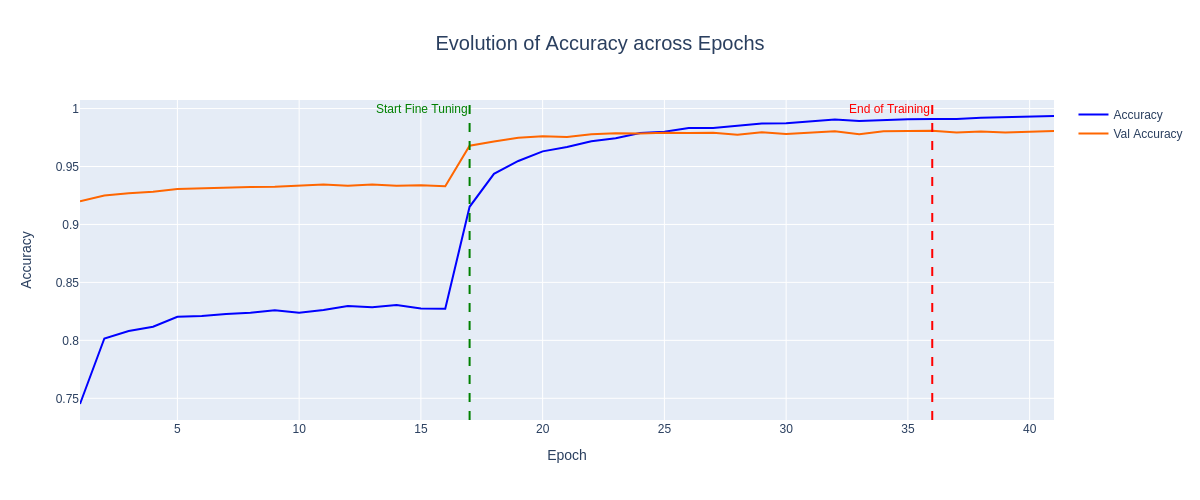

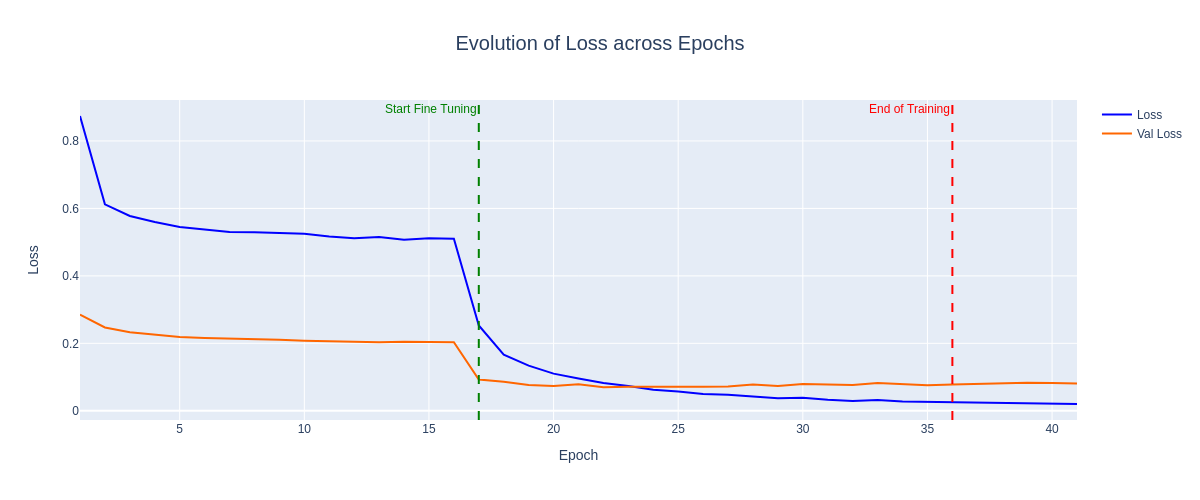

In [ ]:
# Static image for GitHub
plot_metrics(metric="accuracy", renderer="png")
plot_metrics(renderer="png")

### **Confusion Matrix**

In [ ]:
# Extract labels from the test dataset
labels_test = test_dataset.unbatch().map(lambda image, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

# Generate predictions with the trained model
labels_test_pred = model.predict(test_dataset, verbose=0)
labels_test_pred = np.argmax(labels_test_pred, axis=-1)

# Consolidating the accuracy of the test dataset
print("Accuracy:", np.mean(labels_test == labels_test_pred))
print(f"F1 Score: {f1_score(labels_test, labels_test_pred, average='macro')}")

Accuracy: 0.981
F1 Score: 0.9809955399986698


Frequency per Label: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000] 



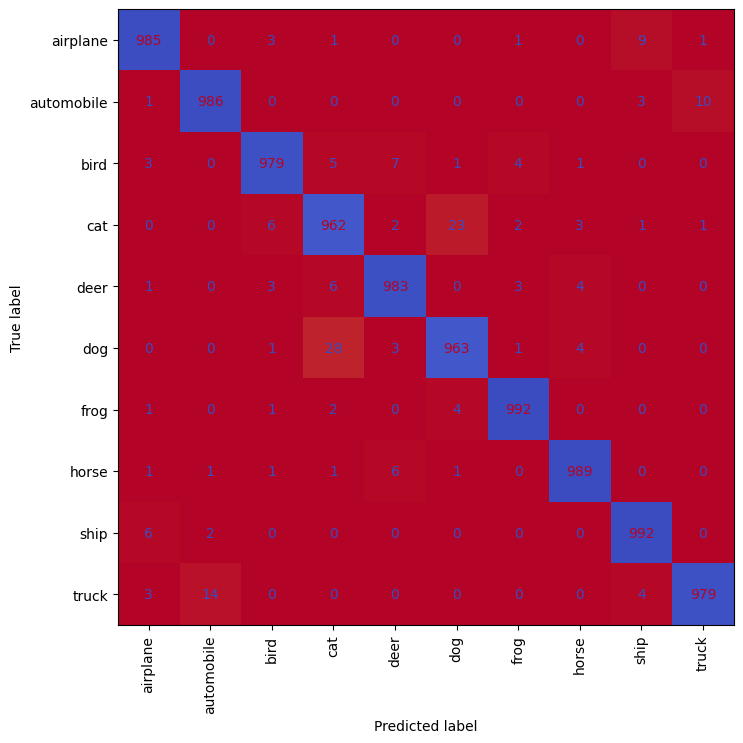

In [ ]:
print("Frequency per Label:", np.unique(labels_test, return_counts=True)[1], "\n")

cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax, colorbar=False, cmap="coolwarm_r", xticks_rotation="vertical");

The test dataset is balanced, with 1,000 images per label. Additionally, the confusion matrix indicates that the model has a slight difficulty distinguishing between the "cat" and "dog" classes, while it correctly classified almost 100% of the "frog" and "ship" categories.

## **Predictions on the test dataset**

In [ ]:
# Extract images from the test dataset
images_test = test_dataset.unbatch().map(lambda image, label: image)
images_test = np.array(list(images_test.as_numpy_iterator()))
images_test = tf.cast(images_test, tf.uint8)

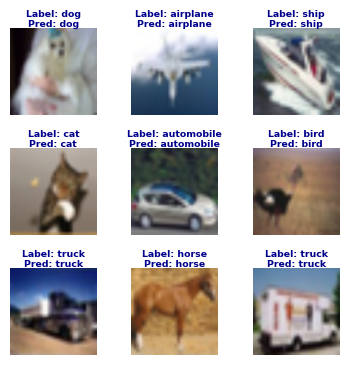

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=9)

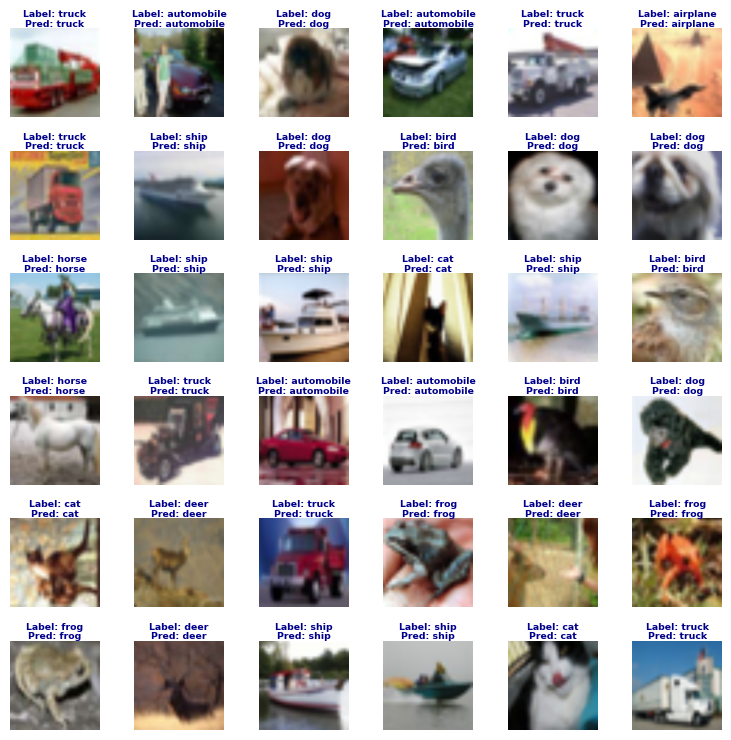

In [ ]:
show_images(images_test, labels_test, labels_test_pred, save=True, path="Image_EfficientNetV2L_CIFAR-10")

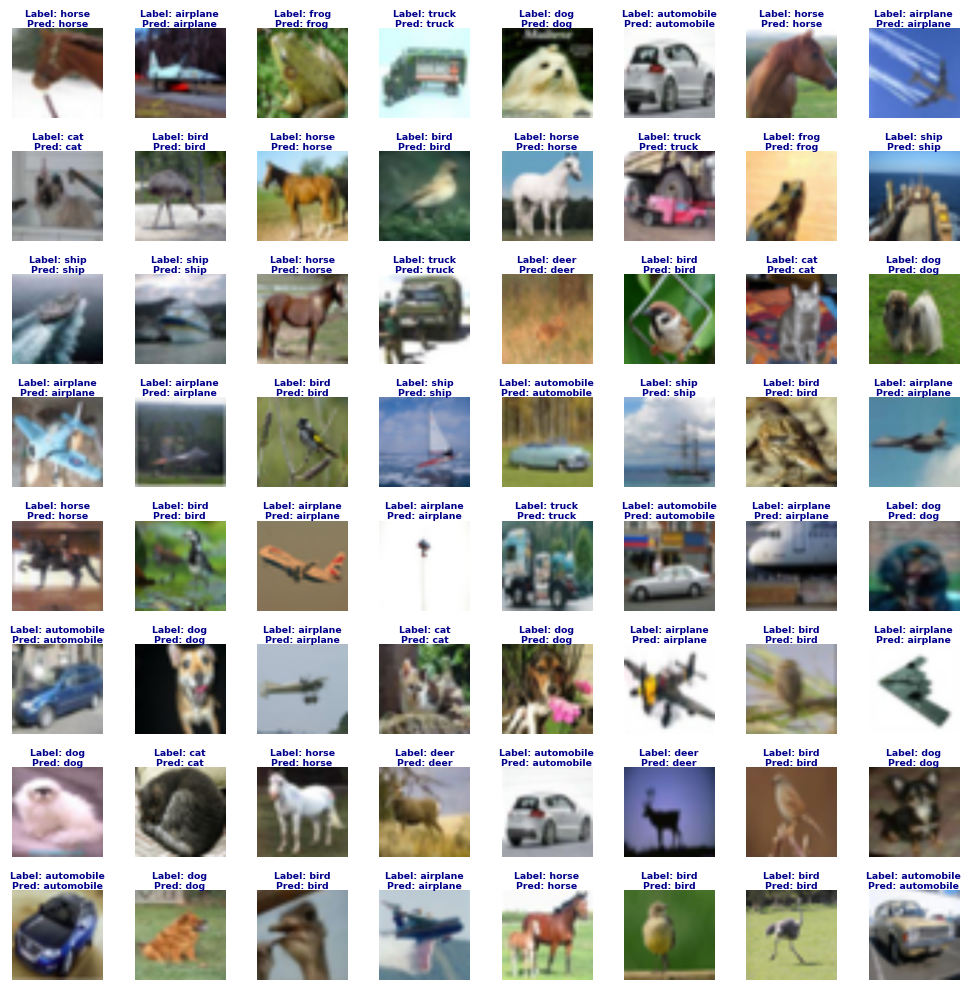

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=64, random=False)

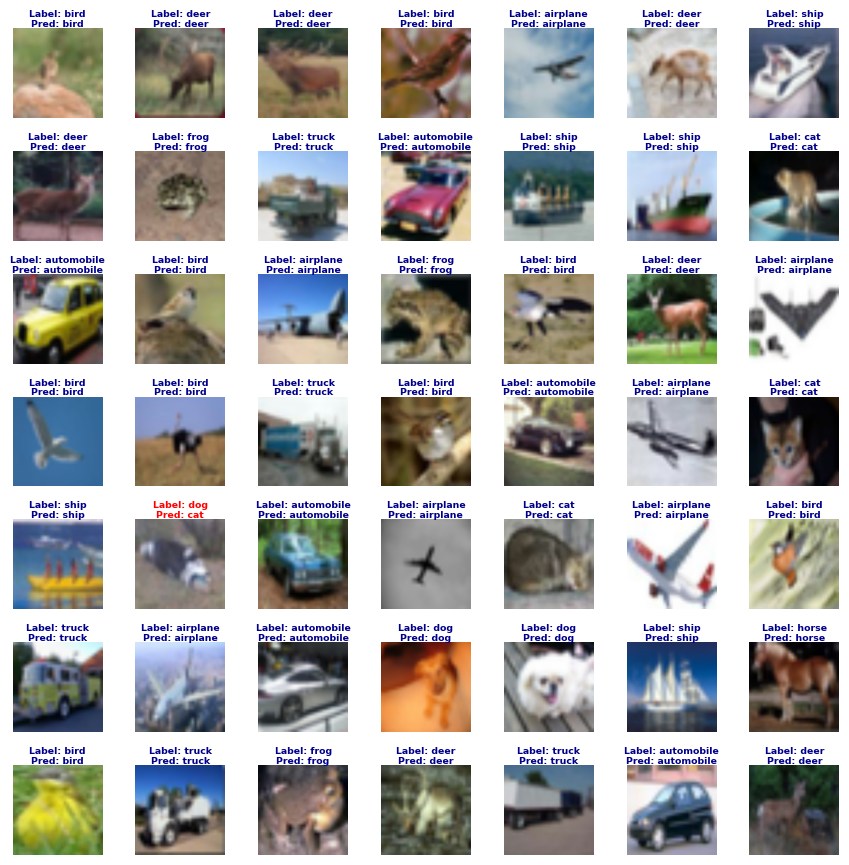

In [ ]:
# This image shows an incorrect prediction
show_images(images_test, labels_test, labels_test_pred, num_examples=49)

**Conclusion:** The model achieved an accuracy of **99.25%** on the training dataset and an accuracy and F1-score of **98.1%** on the test dataset after 36 epochs. These results suggest that the model is highly effective in classifying images in the CIFAR-10 dataset, successfully categorizing most instances while maintaining a good balance between precision and recall. The **1.15%** difference indicates only slight overfitting, implying that the data augmentation and dropout layer were effective. If training were to continue for more epochs, the training accuracy would likely reach 100%, while the test accuracy might begin to decrease or plateau within a certain range, a problem that is avoided thanks to the early stopping callback.

Furthermore, it is important to note that fine-tuning the EfficientNetV2L model improved the accuracy from **93.45%** (achieved after transfer learning) to **98.1%** on the test dataset, highlighting its significance. To achieve even better results, it would be advisable to fine-tune an even more robust pre-trained model than EfficientNetV2L, such as the latest Vision Transformers models.